# Wi-Fi Fingerprinting Experiments (Alternative Version)

## Import modules and set up the environment

In [1]:
# Python Standard Library
import getopt
import os
import sys
import math
import time
import collections
import random

# IPython
from IPython.display import display

# pandas
import pandas as pd
pd.set_option("display.max_rows", 10000)
pd.set_option("display.max_columns", 10000)

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt                       
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator

# seaborn
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()

# NumPy
import numpy as np                                    

# SciPy
import scipy as sp
from scipy.stats import gaussian_kde

# StatsModels
import statsmodels.api as sm

 # scikit-learn
import sklearn                                       
from sklearn import metrics
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneGroupOut

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.pipeline import make_pipeline

<Figure size 432x288 with 0 Axes>

## Helper Functions

In [2]:
def experiment_plots(results, save_to=None, figsize=(8, 8)):
    fig, axarr = plt.subplots(2, 1, figsize=figsize)
    
    for key, result in results.items():
        max_error = math.ceil(result["error"].max())
        kde = gaussian_kde(result["error"].values)
        X_plot=np.linspace(0, max_error, 1000)
        axarr[0].plot(X_plot, kde.evaluate(X_plot), "-", label=key)
    
    axarr[0].set_xlabel("Error (e) in meters (m)")
    axarr[0].set_ylabel(r"$F_X(e)$")
    axarr[0].xaxis.set_major_locator(MultipleLocator(0.5))
    axarr[0].set_xlim(0, result["error"].quantile(q=0.9975))
    axarr[0].legend()

    for key, result in results.items():
        ecdf = sm.distributions.ECDF(result["error"])
        x = np.linspace(min(result["error"]), max(result["error"]))
        y = ecdf(x)
        axarr[1].plot(x, y, label=key)
    
    axarr[1].set_xlabel("Error (e) in meters (m)")
    axarr[1].set_ylabel(r"$f_X(e)$")
    axarr[1].xaxis.set_major_locator(MultipleLocator(0.5))
    axarr[1].yaxis.set_major_locator(MultipleLocator(0.1))
    axarr[1].set_xlim(0, result["error"].quantile(q=0.9975))
    axarr[1].set_ylim(0)
    axarr[1].legend()
    
    fig.tight_layout()
    if save_to is not None:
        fig.savefig(output_data_directory+"/"+save_to, dpi=300)
    plt.show()

def experiment_statistics(result):
    statistics = collections.OrderedDict([
        ("mae",  result["error"].abs().mean()),
        ("rmse", np.sqrt((result["error"]**2).mean())),
        ("sd",   result["error"].std()),
        ("p50",  result["error"].quantile(q=0.50)),
        ("p75",  result["error"].quantile(q=0.75)),
        ("p90",  result["error"].quantile(q=0.90)),
        ("p95",  result["error"].quantile(q=0.95)),
        ("min",  result["error"].min()),
        ("max",  result["error"].max()),
    ])    
    return statistics

def knn_experiment(data, test_data, train_cols, coord_cols,
                   scaler=None, n_neighbors=5, weights="uniform",
                   algorithm="auto", leaf_size=30, p=2, metric="minkowski",
                   metric_params=None, n_jobs=1, leave_out=False):
    result = None
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm,
                              leaf_size=leaf_size, p=p, metric=metric,
                              metric_params=metric_params, n_jobs=n_jobs)
    if scaler is not None:
        estimator = make_pipeline(scaler, knn)
    else:
        estimator = knn
    locations = data.groupby(coord_cols).indices.keys()
    for coords in locations:
        if leave_out:
            train_data = data[(data[coord_cols[0]] != coords[0]) |
                                  (data[coord_cols[1]] != coords[1])].reset_index(drop=True)
        else:
            train_data = data.copy().reset_index(drop=True)
        target_values = test_data[(test_data[coord_cols[0]] == coords[0]) &
                                      (test_data[coord_cols[1]] == coords[1])].reset_index(drop=True)
            
        estimator.fit(train_data[train_cols], train_data[coord_cols])
        predictions = pd.DataFrame(estimator.predict(target_values[train_cols]), columns=coord_cols)
        curr_result = target_values[coord_cols].join(predictions, rsuffix="_predicted")
        error = pd.DataFrame((predictions[coord_cols] - curr_result[coord_cols]).apply(np.linalg.norm, axis=1),
                             columns=["error"])
        curr_result = pd.concat([curr_result, error], axis=1)
        result = pd.concat([result, curr_result])
    return result

def knn_experiment_cv(data, cross_validation, train_cols, coord_cols,    
                      scaler=None, n_neighbors=5, weights='uniform',
                      algorithm="auto", leaf_size=30, p=2, metric="minkowski",
                      metric_params=None, n_jobs=1):    
    result = None
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm,
                              leaf_size=leaf_size, p=p, metric=metric,
                              metric_params=metric_params, n_jobs=n_jobs)
    if scaler is not None:
        estimator = make_pipeline(scaler, knn)
    else:
        estimator = knn
    X = data[train_cols]
    y = data[coord_cols]
    predictions = pd.DataFrame(cross_val_predict(estimator, X, y, cv=cross_validation), columns=coord_cols)
    result = y.join(predictions, rsuffix="_predicted")
    error = pd.DataFrame((predictions[coord_cols] - result[coord_cols]).apply(np.linalg.norm, axis=1), columns=["error"])
    result = pd.concat([result, error], axis=1)    
    return result

### Load the model classes

A class responsible for loading a JSON file (or all the JSON files in a given directory) into a Python dictionary

In [3]:
from yanux.cruncher.model.loader import JsonLoader

A class that takes a set of Python dictionaries containing Wi-Fi logging data loaded from JSON files collected by the YanuX Scavenger Android application

In [4]:
from yanux.cruncher.model.wifi import WifiLogs

## Initialize Input & Output Data Directories and other parameters

In [5]:
input_data_directory = "data"
output_data_directory = "out"
statistics_excel_writer = pd.ExcelWriter(output_data_directory+"/statistics-alt.xlsx")

### Create the output directory if it doesn't exist

In [6]:
if not os.path.exists(output_data_directory):
    os.makedirs(output_data_directory)

## Load Data from the Input Data Directory

Load all files from the *data* folder.
The logs currently placed there were collected using the **Yanux Scavenger** Android application on April 28<sup>th</sup>, 2016 using an LG Nexus 5 running Androdid Marshmallow 6.0.1

In [7]:
json_loader = JsonLoader(input_data_directory+"/wifi-fingerprints")
wifi_logs = WifiLogs(json_loader.json_data)

## Wi-Fi Readings

Number of Recorded Samples per Location

In [8]:
num_samples_per_location = int(len(wifi_logs.wifi_samples()) / len(wifi_logs.locations))
num_samples_per_location

40

Store the data into a Pandas Dataframe, in which each Wi-Fi result reading is represented by a single line

In [9]:
wifi_results_columns = ["filename", "place", "floor", "x", "y", "orientation", "sample_id", "mac_address",
                        "timestamp", "signal_strength"]

wifi_results = pd.DataFrame(wifi_logs.wifi_results(), columns=wifi_results_columns)
wifi_results.to_csv(output_data_directory + "/wifi_results-alt.csv")

Identify the unique MAC Addresses present in the recorded data. Each one represents a single Wi-Fi Access Point.

In [10]:
mac_addresses = wifi_results.mac_address.unique()

Similarly, store the data into a Pandas Dataframe in which each line represents a single sampling cycle with *n* different readings for each of the Access Points within range. Those readings are stored as columns along each sample.

In [11]:
wifi_samples_columns = ["filename", "place", "floor", "x", "y", "orientation", "sample_id", "timestamp"]
wifi_samples_columns.extend(mac_addresses)

wifi_samples = pd.DataFrame(wifi_logs.wifi_samples(), columns=wifi_samples_columns)
wifi_samples = wifi_samples.sort_values(["filename", "x", "y", "floor", "sample_id"]).reset_index(drop=True)
wifi_samples.to_csv(output_data_directory + "/wifi_samples-alt.csv")

## Data Set Statistics

Number of Results

In [12]:
len(wifi_results)

17346

Number of Unique Mac Addresses

In [13]:
len(wifi_results.mac_address.unique())

39

### How often has each Access Point been detected

mac_address
00:0f:60:06:71:2e     33
00:11:21:66:75:80    544
00:11:21:66:75:81    595
00:11:21:66:75:82    639
00:11:21:6c:4e:70    709
00:11:21:6c:4e:71    771
00:11:21:6c:4e:72    792
00:11:21:6c:50:e0    635
00:11:21:6c:50:e1    643
00:11:21:6c:50:e2    647
00:12:43:f1:c4:40     30
00:12:43:f1:c4:41     27
00:12:43:f1:c4:42     30
00:12:80:17:ac:ae     17
00:12:da:9e:31:91      2
00:12:da:9e:32:30    940
00:12:da:9e:32:31    953
00:12:da:9e:32:32    955
00:15:f9:6c:7a:d0    392
00:15:f9:6c:7a:d1    413
00:15:f9:6c:7a:d2    479
00:15:f9:6c:7a:e0    622
00:15:f9:6c:7a:e1    619
00:15:f9:6c:7a:e2    622
00:15:f9:6c:7d:20    669
00:15:f9:6c:7d:21    668
00:15:f9:6c:7d:22    675
00:15:f9:6c:7d:70    956
00:15:f9:6c:7d:71    959
00:15:f9:6c:7d:72    962
00:17:df:7d:70:50     48
00:17:df:7d:70:51     53
00:17:df:7d:70:52     49
00:1b:fc:22:43:4e     50
30:8d:99:64:aa:8d      3
88:e3:ab:11:f4:ee    119
b0:5b:67:c2:a0:16     10
bc:14:01:9c:37:08      8
bc:14:01:9c:37:09      8
dtype: int64

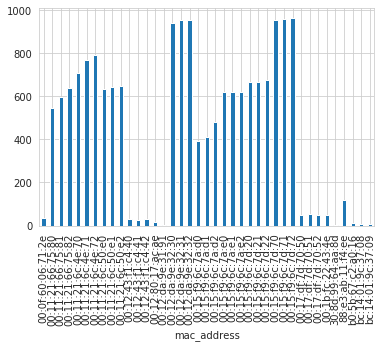

In [14]:
wifi_results_mac_address_group = wifi_results.groupby("mac_address")
wifi_results_mac_address_group.size().plot(kind="bar")
wifi_results_mac_address_group.size()

In [15]:
wifi_results_mac_address_group.size().mean()

444.7692307692308

### How many Wi-Fi results were gathered at each location

x      y    
0.25   0.75     475
2.25   0.75     520
4.25   0.75     527
6.25   0.75     575
8.25   0.75     606
10.25  0.75     679
12.25  0.75     700
13.75  1.25     691
       3.25     831
       5.25     869
       7.25     903
       9.25     887
       11.25    866
15.75  11.25    805
17.75  11.25    828
19.75  11.25    754
21.75  11.25    683
23.75  11.25    729
25.75  11.25    661
27.75  11.25    612
29.75  11.25    601
31.75  11.25    612
33.75  11.25    632
35.75  11.25    632
37.75  11.25    668
dtype: int64

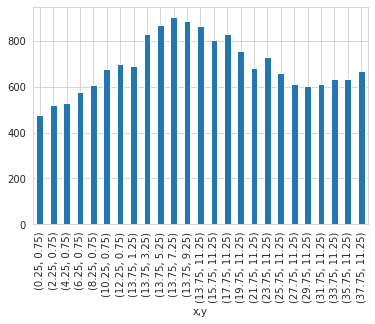

In [16]:
wifi_results_coord_group = wifi_results.groupby(["x", "y"])
wifi_results_coord_group.size().plot(kind="bar")
wifi_results_coord_group.size()

In [17]:
wifi_results_coord_group.size().describe()

count     25.000000
mean     693.840000
std      121.617803
min      475.000000
25%      612.000000
50%      679.000000
75%      805.000000
max      903.000000
dtype: float64

## How many APs were detected at each location

x      y    
0.25   0.75     18
2.25   0.75     19
4.25   0.75     19
6.25   0.75     16
8.25   0.75     18
10.25  0.75     20
12.25  0.75     21
13.75  1.25     21
       3.25     24
       5.25     25
       7.25     26
       9.25     25
       11.25    24
15.75  11.25    24
17.75  11.25    21
19.75  11.25    22
21.75  11.25    18
23.75  11.25    22
25.75  11.25    19
27.75  11.25    19
29.75  11.25    16
31.75  11.25    19
33.75  11.25    21
35.75  11.25    21
37.75  11.25    22
dtype: int64

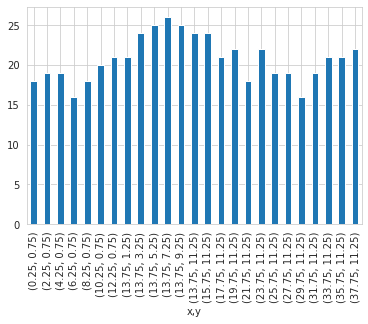

In [18]:
wifi_ap_per_location = wifi_samples.groupby(["x","y"]).min()[wifi_results_mac_address_group.size().keys()].count(axis=1)
wifi_ap_per_location.plot(kind="bar")
wifi_ap_per_location

In [19]:
wifi_ap_per_location.describe()

count    25.000000
mean     20.800000
std       2.768875
min      16.000000
25%      19.000000
50%      21.000000
75%      22.000000
max      26.000000
dtype: float64

### The coordinates of the points where data was captured

(-1.625, 39.625, 0.22499999999999998, 11.775)

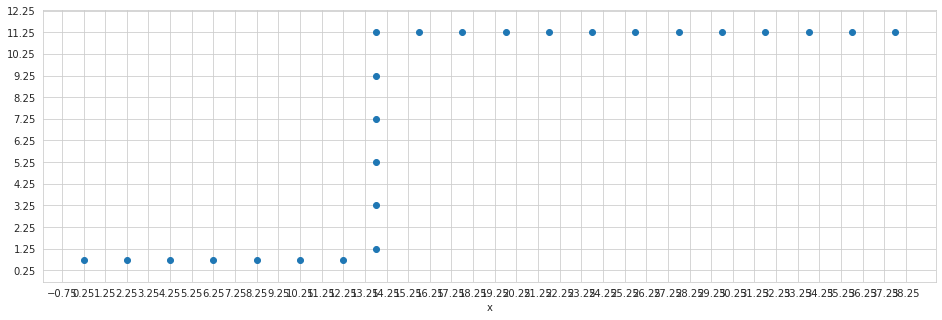

In [20]:
coords = wifi_results[["x","y"]].drop_duplicates().sort_values(by=["x","y"]).reset_index(drop=True)
coords_plot_size = (min(coords["x"].min(),coords["y"].min()), max(coords["x"].max(),coords["y"].max()))
#TODO: If I end up using it in the document, then I should refactor the plot to use matplotlib directly to tweak a few things.
coords.plot(figsize=(16,5), x="x",y="y", style="o", grid=True, legend=False,
            xlim=coords_plot_size, ylim=coords_plot_size,
            xticks=np.arange(coords_plot_size[0]-1, coords_plot_size[1]+1, 1),
            yticks=np.arange(coords_plot_size[0]-1, coords_plot_size[1]+1, 1)).axis('equal')

### Signal Strength Distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f67cc11a390>]],
      dtype=object)

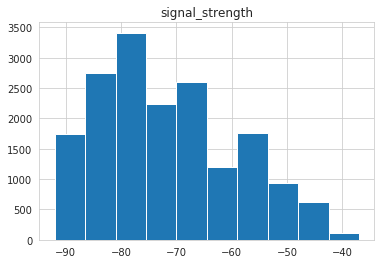

In [21]:
wifi_results.hist(column="signal_strength")

Set a train and test scenario to be used by default when testing.

In [22]:
train_cols = mac_addresses
coord_cols = ["x","y"]

full_data_scenario = wifi_samples.copy()
full_data_scenario_groups = full_data_scenario["x"].map(str)+","+full_data_scenario["y"].map(str)+","+full_data_scenario["filename"].map(str)

default_data_scenario, test_data_scenario, default_data_scenario_groups, test_data_scenario_groups=train_test_split(full_data_scenario, full_data_scenario_groups, test_size=0.3, random_state=42)

default_data_scenario = default_data_scenario.copy().reset_index(drop=True)
test_data_scenario = test_data_scenario.copy().reset_index(drop=True)
default_data_scenario_groups = default_data_scenario_groups.copy().reset_index(drop=True)
test_data_scenario_groups = test_data_scenario_groups.copy().reset_index(drop=True)

## Playground

### Defaults

In [23]:
default_n_neighbors=5
default_weights="distance"
default_metric="manhattan"
default_nan_filler=default_data_scenario[mac_addresses].min().min()*1.010
default_scaler=preprocessing.MinMaxScaler()
default_leave_out=False

DefaultCrossValidator = StratifiedKFold

### Base Example

,mae,rmse,sd,p50,p75,p90,p95,min,max
0,0.214613,0.585155,0.545288,1.776357e-15,7.160097e-15,0.783859,1.436718,0.0,4.414193


No handles with labels found to put in legend.
No handles with labels found to put in legend.


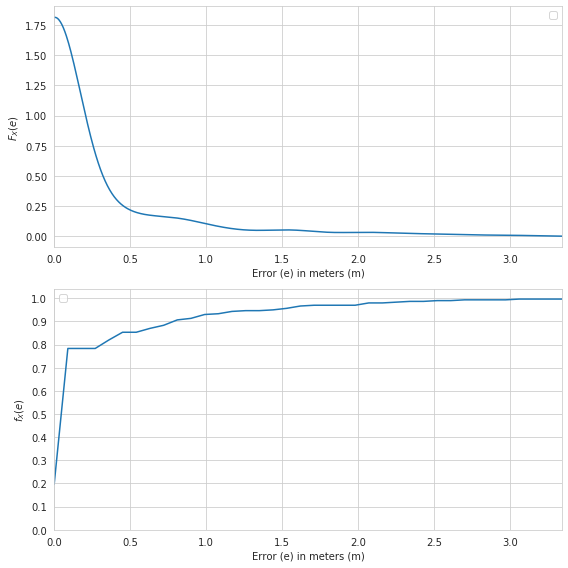

In [24]:
n_neighbors=default_n_neighbors
weights=default_weights
metric=default_metric
nan_filler=default_nan_filler
scaler=default_scaler
leave_out=default_leave_out

curr_data = default_data_scenario.fillna(nan_filler)
test_data = test_data_scenario.fillna(nan_filler)

curr_result = knn_experiment(curr_data,
                             test_data,
                             mac_addresses,
                             coord_cols,
                             scaler=scaler,
                             algorithm="brute",
                             n_neighbors=n_neighbors,
                             weights=weights,
                             metric=metric)

curr_statistics = experiment_statistics(curr_result)    
curr_result.to_csv(output_data_directory+"/results-base-alt.csv")

statistics_table = pd.DataFrame([curr_statistics], columns=list(curr_statistics.keys()))
statistics_table.to_csv(output_data_directory+"/statistics-base-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "base")

#show table
display(statistics_table)
#plots
experiment_plots({'':curr_result})

### # Neighbors & Distance Weights

,k,weights,mae,rmse,sd,p50,p75,p90,p95,min,max
3,2,distance,0.143930,0.601495,0.584438,8.950904e-16,2.512148e-15,7.324107e-15,1.010507e+00,0.0,6.000000
5,3,distance,0.184592,0.604463,0.576000,1.776357e-15,3.555747e-15,6.519059e-01,1.320393e+00,0.0,6.000000
2,2,uniform,0.145714,0.604743,0.587345,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.0,6.000000
7,4,distance,0.214179,0.616733,0.578762,1.776357e-15,7.105427e-15,8.077638e-01,1.043561e+00,0.0,6.000000
4,3,uniform,0.193333,0.621825,0.591429,0.000000e+00,0.000000e+00,6.666667e-01,1.333333e+00,0.0,6.000000
9,5,distance,0.242070,0.630289,0.582367,1.779823e-15,3.047222e-01,7.569688e-01,1.250998e+00,0.0,5.229685
6,4,uniform,0.229286,0.642262,0.600369,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.0,6.000000
11,6,distance,0.271671,0.655923,0.597444,3.552714e-15,2.986550e-01,8.800277e-01,1.561888e+00,0.0,5.345982
8,5,uniform,0.261595,0.661017,0.607485,0.000000e+00,4.000000e-01,8.000000e-01,1.600000e+00,0.0,5.200000
13,7,distance,0.305785,0.675463,0.602715,3.972055e-15,4.081605e-01,8.662581e-01,1.464787e+00,0.0,5.430794


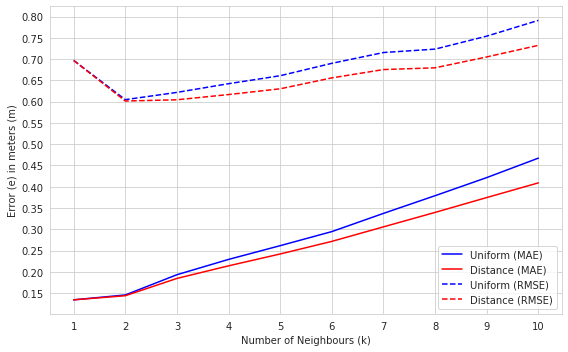

In [25]:
metric=default_metric
nan_filler=default_nan_filler
scaler=default_scaler

n_neighbors=np.arange(1,11,1)
weights=["uniform", "distance"]


cross_validation = DefaultCrossValidator()
y = default_data_scenario_groups

curr_data  = default_data_scenario.fillna(nan_filler)

# Just a statistics accumulator
statistics = []
for k in n_neighbors:
    for w in weights:
        curr_result = knn_experiment_cv(curr_data,
                                        cross_validation.split(curr_data[mac_addresses],
                                                               y,
                                                               groups=default_data_scenario_groups),
                                        mac_addresses,
                                        coord_cols,
                                        scaler=scaler,
                                        algorithm="brute",
                                        n_neighbors=k,
                                        weights=w,
                                        metric=metric)
        
        curr_statistics = experiment_statistics(curr_result)
        curr_statistics["k"] = k
        curr_statistics["weights"] = w
        statistics.append(curr_statistics)
    
cols = ["k","weights"] + list(curr_statistics.keys())[:-2]
statistics_table = pd.DataFrame(statistics, columns=cols)
statistics_table.to_csv(output_data_directory + "/statistics-neighbors-weights-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "neighbors-weights")

#show table
display(statistics_table.sort_values(cols[3:]))

# Plotting Error statistics
fig, ax = plt.subplots(figsize=(8, 5))
index = n_neighbors

ax.plot(index, statistics_table[statistics_table["weights"] == "uniform"]["mae"].tolist(),
         color="b", ls="-", label="Uniform (MAE)")

ax.plot(index, statistics_table[statistics_table["weights"] == "distance"]["mae"].tolist(),
         color="r", ls="-", label="Distance (MAE)")

ax.plot(index, statistics_table[statistics_table["weights"] == "uniform"]["rmse"].tolist(),
         color="b", ls="--", label="Uniform (RMSE)")

ax.plot(index, statistics_table[statistics_table["weights"] == "distance"]["rmse"].tolist(),
         color="r", ls="--", label="Distance (RMSE)")

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

ax.set_xlabel("Number of Neighbours (k)")
ax.set_ylabel("Error (e) in meters (m)")

plt.legend()
plt.tight_layout()
plt.savefig(output_data_directory+"/plot-neighbors_weights-alt.pdf", dpi=300)
plt.show()

### Metric
Just test a few different distance statistics to assess if there is a better alternative than the plain old *euclidean* distance. The tested statistics include:
- Euclidean Distance
    - sqrt(sum((x - y)^2))
- Manhattan Distance
    - sum(|x - y|) 
- Chebyshev Distance
    - sum(max(|x - y|))
- Hamming Distance
    - N_unequal(x, y) / N_tot
- Canberra Distance
    - sum(|x - y| / (|x| + |y|))
- Braycurtis Similarity
    - sum(|x - y|) / (sum(|x|) + sum(|y|))

,metric,mae,rmse,sd,p50,p75,p90,p95,min,max
1,manhattan,0.242070,0.630289,0.582367,1.779823e-15,0.304722,0.756969,1.250998,0.0,5.229685
3,braycurtis,0.250370,0.639683,0.589071,1.776357e-15,0.311967,0.787569,1.443921,0.0,5.243603
0,euclidean,0.428168,0.887805,0.778289,3.557047e-15,0.683633,1.285527,1.915980,0.0,6.416316
2,canberra,0.480304,0.901385,0.763305,2.299118e-01,0.705121,1.388534,1.857562,0.0,6.000000


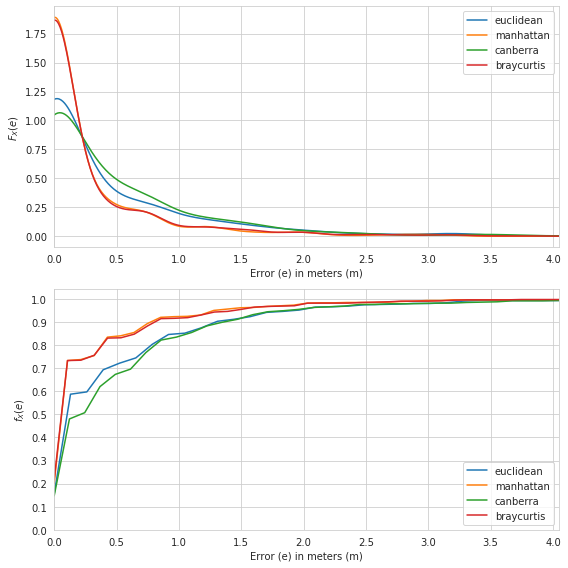

In [26]:
n_neighbors=default_n_neighbors
weights=default_weights
nan_filler=default_nan_filler
scaler=default_scaler

distance_statistics=["euclidean", "manhattan", "canberra", "braycurtis"]

cross_validation = DefaultCrossValidator()
y = default_data_scenario_groups

curr_data = default_data_scenario.fillna(nan_filler)
# Results and statistics accumulators
results = {}
statistics = []
for metric in distance_statistics:
    curr_result = knn_experiment_cv(curr_data,
                                    cross_validation.split(curr_data[mac_addresses],
                                                           y,
                                                           groups=default_data_scenario_groups),
                                    mac_addresses,
                                    coord_cols,
                                    scaler=scaler,
                                    algorithm="brute",
                                    n_neighbors=n_neighbors,
                                    weights=weights,
                                    metric=metric)
    results[metric] = curr_result
    curr_statistics = experiment_statistics(curr_result)
    curr_statistics["metric"] = metric
    statistics.append(curr_statistics)
    
cols = ["metric"] + list(curr_statistics.keys())[:-1]
statistics_table = pd.DataFrame(statistics, columns=cols)
statistics_table.to_csv(output_data_directory + "/statistics-metric-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "metric")
#show table
display(statistics_table.sort_values(cols[2:]))
#plots
experiment_plots(results, "plot-metric-alt.pdf")

### Feature Scaling
Test different data scaling and normalization approaches to find out if any of them provides a clear advantage over the others.

,scaler,mae,rmse,sd,p50,p75,p90,p95,min,max
1,Rescaling,0.242070,0.630289,0.582367,1.779823e-15,3.047222e-01,0.756969,1.250998,0.0,5.229685
2,Standardization,0.289667,0.694746,0.631930,1.790181e-15,3.455447e-01,0.948713,1.575128,0.0,6.000000
0,No Scaling,0.242080,0.727072,0.686078,1.776357e-15,7.479107e-15,0.771037,1.275748,0.0,8.000000


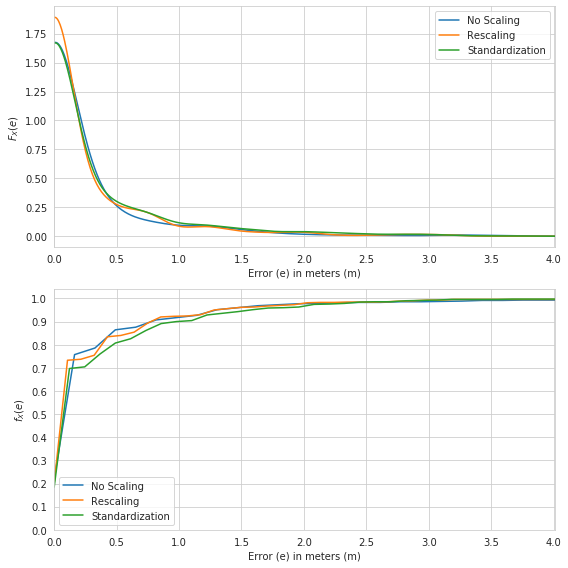

In [27]:
n_neighbors=default_n_neighbors
weights=default_weights
metric=default_metric
nan_filler=default_nan_filler

cross_validation = DefaultCrossValidator()
y = default_data_scenario_groups

scalers = {"No Scaling": None,
           "Rescaling": preprocessing.MinMaxScaler(),
           "Standardization": preprocessing.StandardScaler()}
# Results and statistics accumulators
results = {}
statistics = []
for scaler_name, scaler in scalers.items():
    curr_data = default_data_scenario.fillna(nan_filler)
    curr_result = knn_experiment_cv(curr_data,
                                    cross_validation.split(curr_data[mac_addresses],
                                                           y,
                                                           groups=default_data_scenario_groups),
                                    mac_addresses,
                                    coord_cols,
                                    scaler=scaler,
                                    algorithm="brute",
                                    n_neighbors=n_neighbors,
                                    weights=weights,
                                    metric=metric)
    results[scaler_name] = curr_result
    curr_statistics = experiment_statistics(results[scaler_name])
    curr_statistics["scaler"] = scaler_name
    statistics.append(curr_statistics)

cols = ["scaler"] + list(curr_statistics.keys())[:-1]
statistics_table = pd.DataFrame(statistics, columns=cols)
statistics_table.to_csv(output_data_directory + "/statistics-feature_scaling-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "feature_scaling")
#show table
display(statistics_table.sort_values(cols[2:]))
#plots
experiment_plots(results, "plot-feature_scaling-alt.pdf")

### NaN filler values
Test which is the signal strength value that should be considered for Access Points that are currently out of range. This is needed as part of the process of computing the distance/similarity between different fingerprints.

,nan_filler,mae,rmse,sd,p50,p75,p90,p95,min,max
2,-92.920,0.242070,0.630289,0.582367,1.779823e-15,0.304722,0.756969,1.250998,0.0,5.229685
1,-92.092,0.242739,0.641609,0.594344,1.776357e-15,0.278898,0.773642,1.287057,0.0,5.220981
0,-92.000,0.243784,0.641842,0.594167,1.776357e-15,0.291744,0.773441,1.291684,0.0,5.219978
3,-101.200,0.330756,0.742395,0.665119,3.552714e-15,0.377608,1.065112,1.587956,0.0,5.305495
4,-138.000,0.608703,1.106384,0.924546,2.994321e-01,0.832192,1.662630,2.294339,0.0,7.538516


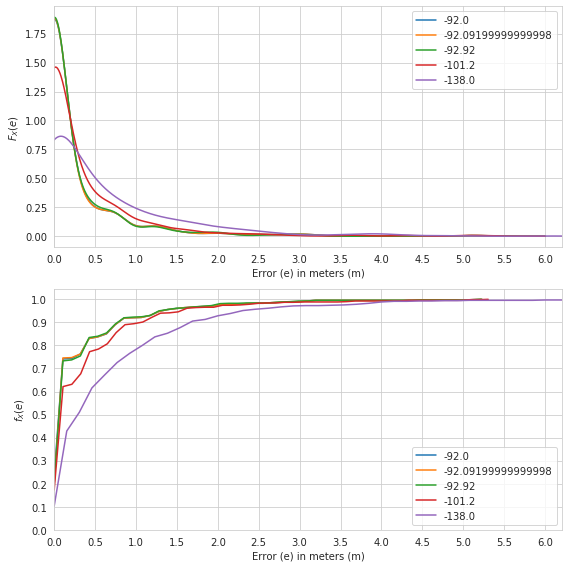

In [28]:
n_neighbors=default_n_neighbors
weights=default_weights
metric=default_metric
scaler=default_scaler

min_rssi_value = default_data_scenario[mac_addresses].min().min()
nan_fillers = [min_rssi_value,min_rssi_value*1.001,min_rssi_value*1.010,min_rssi_value*1.100,min_rssi_value*1.500]

cross_validation = DefaultCrossValidator()
y = default_data_scenario_groups

# Results and statistics accumulators
results = {}
statistics = []
for nf in nan_fillers:
    curr_data = default_data_scenario.fillna(nf)
    curr_result = knn_experiment_cv(curr_data,
                                    cross_validation.split(curr_data[mac_addresses],
                                                           y,
                                                           groups=default_data_scenario_groups),
                                    mac_addresses,
                                    coord_cols,
                                    scaler=scaler,
                                    algorithm="brute",
                                    n_neighbors=n_neighbors,
                                    weights=weights,
                                    metric=metric)
    results[nf] = curr_result
    curr_statistics = experiment_statistics(curr_result)
    curr_statistics["nan_filler"] = nf
    statistics.append(curr_statistics)

cols = ["nan_filler"] + list(curr_statistics.keys())[:-1]
statistics_table = pd.DataFrame(statistics, columns=cols)
statistics_table.to_csv(output_data_directory + "/statistics-nan_filler-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "nan_filler")
#show table
display(statistics_table.sort_values(cols[2:]))
#plots
experiment_plots(results, "plot-nan_filler-alt.pdf")

## Grid Search - Automatically searching for the best estimator parameters

In [29]:
k_neighbors_values = range(1,31,1)
weights_values = [
                    "uniform",
                    "distance"
                 ]
metric_values = [
                    "euclidean",
                    "manhattan",
                    "canberra", 
                    "braycurtis"
                ]
algorithm_values = ["brute"]

nan_filler=default_nan_filler

curr_data = default_data_scenario.fillna(nan_filler)

param_grid = {
                "kneighborsregressor__n_neighbors": list(k_neighbors_values),
                "kneighborsregressor__weights": weights_values,
                "kneighborsregressor__metric": metric_values,
                "kneighborsregressor__algorithm": algorithm_values,
              }

scaler = preprocessing.StandardScaler()

cross_validation = DefaultCrossValidator()
y = default_data_scenario_groups

estimator = make_pipeline(preprocessing.StandardScaler(), KNeighborsRegressor())

grid = GridSearchCV(estimator,
                    param_grid=param_grid,
                    cv=cross_validation.split(curr_data[mac_addresses], y, groups=default_data_scenario_groups),
                    n_jobs=1,
                    scoring=sklearn.metrics.make_scorer(sklearn.metrics.mean_squared_error,
                                                        greater_is_better=False,
                                                        multioutput="uniform_average"))

grid.fit(curr_data[mac_addresses], curr_data[coord_cols], default_data_scenario_groups)
print("Best parameters set found on development set:")
print(grid.best_params_)

#print("Grid scores on development set:")
#gridcv_results = pd.DataFrame(grid.cv_results_)
#gridcv_results[['mean_test_score', 'std_test_score', 'params']]

Best parameters set found on development set:
{'kneighborsregressor__algorithm': 'brute', 'kneighborsregressor__metric': 'manhattan', 'kneighborsregressor__n_neighbors': 3, 'kneighborsregressor__weights': 'distance'}


### Impact of orientation in the results

,orientation,mae,rmse,sd,p50,p75,p90,p95,min,max
8,Train: right-to-left-point Test: right-to-left...,0.097753,0.272958,0.255708,1.776357e-15,3.972055e-15,0.396635,0.756576,0.0,1.150004
2,Train: all Test: right-to-left-point,0.167185,0.498028,0.470700,1.776357e-15,3.972055e-15,0.565260,0.929651,0.0,2.979789
0,Train: all Test: all,0.214613,0.585155,0.545288,1.776357e-15,7.160097e-15,0.783859,1.436718,0.0,4.414193
4,Train: left-to-right-point Test: left-to-right...,0.192205,0.586492,0.555960,1.810604e-15,6.679715e-15,0.669441,1.256118,0.0,4.552083
1,Train: all Test: left-to-right-point,0.262042,0.660894,0.608757,1.779823e-15,6.214795e-04,0.929930,1.580274,0.0,4.414193
3,Train: left-to-right-point Test: all,0.789598,1.362333,1.112029,2.754585e-01,1.212916e+00,2.398524,3.390882,0.0,4.552083
6,Train: right-to-left-point Test: all,0.802249,1.508162,1.279221,7.105427e-15,1.166165e+00,2.422661,4.000000,0.0,6.000000
5,Train: left-to-right-point Test: right-to-left...,1.386991,1.835192,1.205768,1.180706e+00,2.000000e+00,3.217419,4.000000,0.0,4.362789
7,Train: right-to-left-point Test: left-to-right...,1.506745,2.115325,1.489670,1.168172e+00,2.000000e+00,4.000000,4.035137,0.0,6.000000


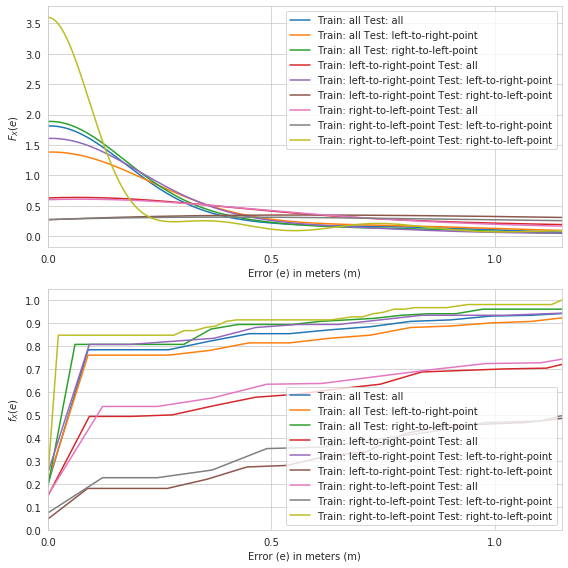

In [30]:
filename_prefixes = ["left-to-right-point", "right-to-left-point"]
filename_prefix_data_scenarios = {}
filename_prefix_data_scenarios["all"] = default_data_scenario
for filename_prefix in filename_prefixes:
    filename_prefix_data_scenarios[filename_prefix] = default_data_scenario[default_data_scenario["filename"].str.startswith(filename_prefix)].reset_index(drop=True)

filename_prefix_test_data_scenarios = {}
filename_prefix_test_data_scenarios["all"] = test_data_scenario
for filename_prefix in filename_prefixes:
    filename_prefix_test_data_scenarios[filename_prefix] = test_data_scenario[test_data_scenario["filename"].str.startswith(filename_prefix)].reset_index(drop=True)

n_neighbors=default_n_neighbors
weights=default_weights
metric=default_metric
nan_filler=default_nan_filler
scaler=default_scaler

# Results and statistics accumulators
results = {}
statistics = []
for train_data_keys, train_data in filename_prefix_data_scenarios.items():
    for test_data_keys, test_data in filename_prefix_test_data_scenarios.items():
        curr_data = train_data.fillna(nan_filler)
        curr_test_data = test_data.fillna(nan_filler)
        curr_result = knn_experiment(curr_data,
                                     curr_test_data,
                                     mac_addresses,
                                     coord_cols,
                                     scaler=scaler,
                                     algorithm="brute",
                                     n_neighbors=n_neighbors,
                                     weights=weights,
                                     metric=metric)
        label = "Train: "+train_data_keys+" Test: "+test_data_keys
        results[label] = curr_result
        curr_statistics = experiment_statistics(curr_result)
        curr_statistics["orientation"] = label
        statistics.append(curr_statistics)

cols = ["orientation"] + list(curr_statistics.keys())[:-1]
statistics_table = pd.DataFrame(statistics, columns=cols)
statistics_table.to_csv(output_data_directory + "/statistics-orientation-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "orientation")
#show table
display(statistics_table.sort_values(cols[2:]))
#plots
experiment_plots(results, "plot-orientation-alt.pdf")

### Impact of the spacing between reference points in the results

,reference_points_spacing,mae,rmse,sd,p50,p75,p90,p95,min,max
1,even,2.009338,2.372200,1.262814,2.0,2.413005,3.265559,4.125478,0.029064,7.468717
2,all,2.244906,2.555935,1.222579,2.0,2.771833,4.000000,4.390628,0.017946,9.563781
0,odd,2.270341,2.614648,1.298660,2.0,2.846831,4.000000,4.391950,0.024538,10.685673


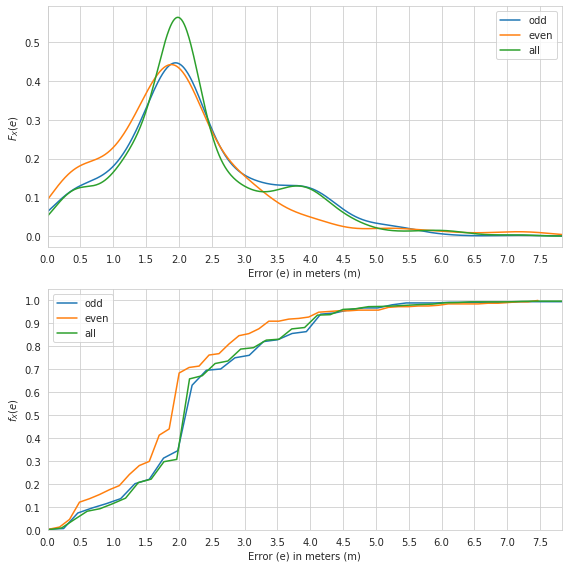

In [31]:
subset_reference_points_scenarios = {}
coords_indices = default_data_scenario.groupby(coord_cols).indices

odd_coords_keys = list(coords_indices.keys())[0::2]
odd_ids = []
for key in odd_coords_keys:
    odd_ids.extend(coords_indices[key])

even_coords_keys = list(coords_indices.keys())[1::2]
even_ids = []
for key in even_coords_keys:
    even_ids.extend(coords_indices[key])

subset_reference_points_scenarios["odd"] = full_data_scenario.loc[odd_ids].reset_index(drop=True)
subset_reference_points_scenarios["even"] = full_data_scenario.loc[even_ids].reset_index(drop=True)
subset_reference_points_scenarios["all"] = full_data_scenario

n_neighbors=default_n_neighbors
weights=default_weights
metric=default_metric
nan_filler=default_nan_filler
scaler=default_scaler
# Results and statistics accumulators
results = {}
statistics = []
for train_data_keys, train_data in subset_reference_points_scenarios.items():
    curr_data = train_data.fillna(nan_filler)
    
    cross_validation = LeaveOneGroupOut()
    curr_data_scenario_groups = curr_data["x"].map(str)+","+curr_data["y"].map(str)
    y = curr_data_scenario_groups
    
    curr_result = knn_experiment_cv(curr_data,
                                    cross_validation.split(curr_data[mac_addresses],
                                                           y,
                                                           groups=curr_data_scenario_groups),
                                    mac_addresses,
                                    coord_cols,
                                    scaler=scaler,
                                    algorithm="brute",
                                    n_neighbors=n_neighbors,
                                    weights=weights,
                                    metric=metric)
    results[train_data_keys] = curr_result
    curr_statistics = experiment_statistics(curr_result)
    curr_statistics["reference_points_spacing"] = train_data_keys
    statistics.append(curr_statistics)

cols = ["reference_points_spacing"] + list(curr_statistics.keys())[:-1]
statistics_table = pd.DataFrame(statistics, columns=cols)
statistics_table.to_csv(output_data_directory + "/statistics-reference_points_spacing-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "reference_points_spacing")
#show table
display(statistics_table.sort_values(cols[2:]))
#plots
experiment_plots(results, "plot-reference_points_spacing-alt.pdf")

### Impact of the amount of available data in the results

,partial_data,mae,rmse,sd,p50,p75,p90,p95,min,max
1,0.90,0.217281,0.623891,0.584897,1.776357e-15,7.324107e-15,0.739181,1.207224,0.0,6.000000
2,0.70,0.260656,0.680282,0.628455,1.779823e-15,3.184593e-01,0.787869,1.465388,0.0,6.000000
0,1.00,0.276172,0.715980,0.660639,1.779823e-15,3.407671e-01,0.833503,1.547623,0.0,6.000000
3,0.50,0.349070,0.767144,0.683262,3.552714e-15,3.935892e-01,1.132745,1.558592,0.0,6.000000
4,0.30,0.576546,0.914850,0.710551,3.515825e-01,7.682952e-01,1.391995,1.893255,0.0,9.175579
5,0.25,0.671094,0.987911,0.725274,4.687274e-01,8.889697e-01,1.468011,2.071929,0.0,5.805521


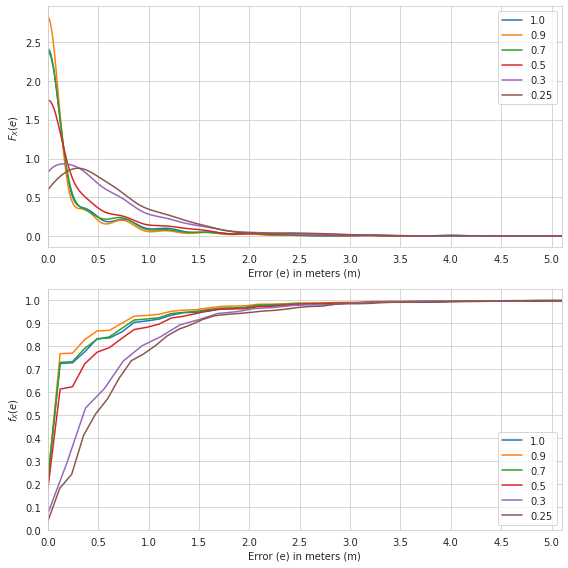

In [32]:
n_neighbors=default_n_neighbors
weights=default_weights
metric=default_metric
nan_filler=default_nan_filler
scaler=default_scaler

partial_data = [1.0, 0.9, 0.7, 0.5, 0.3, 0.25]
repetitions = 5
train_data = full_data_scenario[mac_addresses].copy()
target_values = full_data_scenario[coord_cols].copy()
target_values["label"] = full_data_scenario["x"].map(str) + "," + full_data_scenario["y"].map(str)+ "," + full_data_scenario["filename"].map(str)

# Results and statistics accumulators
results = {}
statistics = []
for partial in partial_data:
    curr_result = pd.DataFrame()
    for repetition in range(repetitions):
        if partial == 1.0:
            X_train = train_data
            y_train = target_values
        else:
            X_train, X_test, y_train, y_test = train_test_split(train_data,
                                                                target_values,
                                                                test_size=1-partial,
                                                                stratify=target_values["label"].values)

        train_split_data = pd.concat([y_train, X_train], axis=1).reset_index(drop=True)
        curr_data = train_split_data.fillna(nan_filler)
        
        cross_validation = DefaultCrossValidator()
        curr_data_scenario_groups = curr_data["x"].map(str)+","+curr_data["y"].map(str)
        y = curr_data_scenario_groups
        
        curr_result = curr_result.append(knn_experiment_cv(curr_data,
                                                           cross_validation.split(curr_data[mac_addresses],
                                                                                  y,
                                                                                  groups=curr_data_scenario_groups),
                                                            mac_addresses,
                                                            coord_cols,
                                                            scaler=scaler,
                                                            algorithm="brute",
                                                            n_neighbors=n_neighbors,
                                                            weights=weights,
                                                            metric=metric), ignore_index=True)
    results[partial] = curr_result
    curr_statistics = experiment_statistics(curr_result)
    curr_statistics["partial_data"] = partial
    statistics.append(curr_statistics)

cols = ["partial_data"] + list(curr_statistics.keys())[:-1]
statistics_table = pd.DataFrame(statistics, columns=cols)
statistics_table.to_csv(output_data_directory + "/statistics-partial_data-alt.csv")
statistics_table.to_excel(statistics_excel_writer, "partial_data")
#show table
display(statistics_table.sort_values(cols[2:]))
#plots
experiment_plots(results, "plot-partial_data-alt.pdf")

#### Save all the data that was collected into an Excel file

In [33]:
statistics_excel_writer.save()